In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
df = pd.read_csv('data/final_combined_dataset.csv')


In [3]:
df = df.drop(columns=['nearby_cases_weighted','city'])

In [4]:
df.head(10)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k
0,2012-01-01,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652
1,2012-01-08,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565
2,2012-01-15,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793
3,2012-01-22,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641
4,2012-01-29,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608
5,2012-02-05,201206,39,207044,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,3300100,0.857159,0.858000,3.8170,25.9830,3.8228,26.0478,-44.319627,-23.009116,18.836576
6,2012-02-12,201207,37,207044,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,3300100,0.858241,0.858000,4.0861,29.4086,4.0920,29.0110,-44.319627,-23.009116,17.870598
7,2012-02-19,201208,33,207044,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,3300100,0.859142,0.858000,0.5962,4.0133,0.4783,3.2643,-44.319627,-23.009116,15.938641
8,2012-02-26,201209,46,207044,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,3300100,0.860082,0.858000,0.8143,3.8456,0.8171,3.8703,-44.319627,-23.009116,22.217500
9,2012-03-04,201210,42,207044,20.428571,71.714286,48.333639,28.428571,26.467491,30.857143,3300100,0.860933,0.861567,1.1867,5.3867,0.6647,3.8741,-44.319627,-23.009116,20.285543


<Axes: >

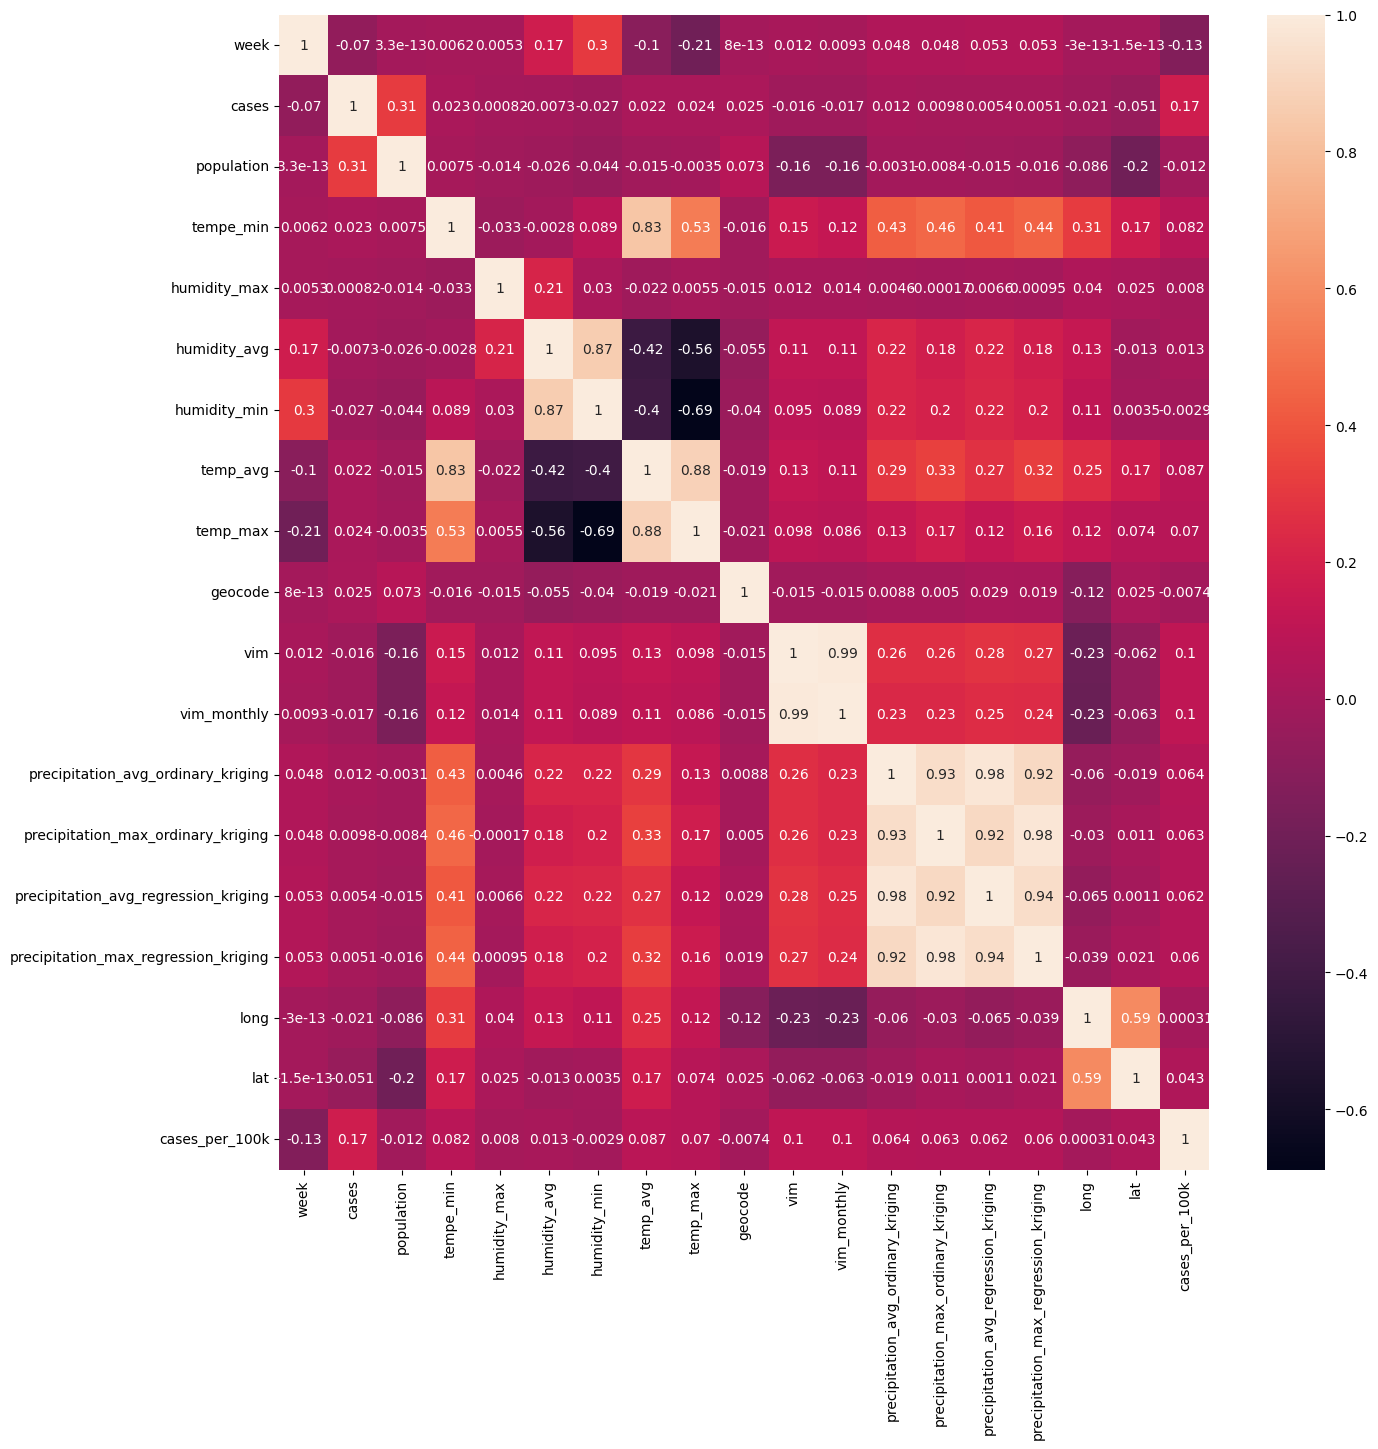

In [5]:
s = df.select_dtypes(include="number").corr()
plt.figure(figsize=(15,15))
sns.heatmap(s,annot=True)

In [6]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

ADDING CYCLIC FEATURES

In [7]:
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52234 entries, 0 to 52233
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  52234 non-null  datetime64[ns]
 1   week                                  52234 non-null  int64         
 2   cases                                 52234 non-null  int64         
 3   population                            52234 non-null  int64         
 4   tempe_min                             52234 non-null  float64       
 5   humidity_max                          52234 non-null  float64       
 6   humidity_avg                          52234 non-null  float64       
 7   humidity_min                          52234 non-null  float64       
 8   temp_avg                              52234 non-null  float64       
 9   temp_max                              52234 non-null  float64       
 10

In [9]:
# columns = df.columns
# print(columns)
df = df[df['geocode'] == 3303807]

In [10]:
# Adding a lag feature for the previous time step (1 lag)
df['cases_lag1'] = df['cases'].shift(1)

# Adding multiple lags (e.g., 2 lags)
df['cases_lag2'] = df['cases'].shift(2)


df['cases_lag3'] = df['cases'].shift(3)

# Adding multiple lags (e.g., 2 lags)
df['cases_lag4'] = df['cases'].shift(4)

df

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,year,month,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
29274,2012-01-01,201201,1,43680,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,...,2012,1,5.000000e-01,0.866025,1.000000,7.185429e-13,NaN,NaN,NaN,NaN
29275,2012-01-08,201202,0,43680,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,...,2012,1,5.000000e-01,0.866025,0.992709,-1.205367e-01,1.0,NaN,NaN,NaN
29276,2012-01-15,201203,2,43680,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,...,2012,1,5.000000e-01,0.866025,0.970942,-2.393157e-01,0.0,1.0,NaN,NaN
29277,2012-01-22,201204,3,43680,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,...,2012,1,5.000000e-01,0.866025,0.935016,-3.546049e-01,2.0,0.0,1.0,NaN
29278,2012-01-29,201205,2,43680,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,...,2012,1,5.000000e-01,0.866025,0.885456,-4.647232e-01,3.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29843,2022-11-27,202248,0,43680,18.857143,99.151789,79.717112,62.238677,23.775511,27.857143,...,2022,11,-5.000000e-01,0.866025,0.663123,-7.485107e-01,7.0,11.0,10.0,15.0
29844,2022-12-04,202249,3,43680,20.285714,100.000000,77.826146,58.211681,25.071428,28.857143,...,2022,12,-2.449294e-16,1.000000,0.568065,-8.229839e-01,0.0,7.0,11.0,10.0
29845,2022-12-11,202250,3,43680,18.833333,98.002307,77.462712,61.559047,23.904762,27.833333,...,2022,12,-2.449294e-16,1.000000,0.464723,-8.854560e-01,3.0,0.0,7.0,11.0
29846,2022-12-18,202251,8,43680,19.500000,96.987255,82.448150,74.983709,22.517858,24.500000,...,2022,12,-2.449294e-16,1.000000,0.354605,-9.350162e-01,3.0,3.0,0.0,7.0


In [11]:
train_df = df[df['date'].dt.year <= 2020]
test_df = df[df['date'].dt.year >= 2021]

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (470, 31)
Test set shape: (104, 31)


In [12]:
# Remove the first 4 rows from train_df
train_df = train_df.iloc[4:].reset_index(drop=True)

train_df

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,year,month,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
0,2012-01-29,201205,2,43680,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,...,2012,1,5.000000e-01,0.866025,0.885456,-0.464723,3.0,2.0,0.0,1.0
1,2012-02-05,201206,1,43680,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,...,2012,2,8.660254e-01,0.500000,0.822984,-0.568065,2.0,3.0,2.0,0.0
2,2012-02-12,201207,3,43680,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,...,2012,2,8.660254e-01,0.500000,0.748511,-0.663123,1.0,2.0,3.0,2.0
3,2012-02-19,201208,3,43680,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,...,2012,2,8.660254e-01,0.500000,0.663123,-0.748511,3.0,1.0,2.0,3.0
4,2012-02-26,201209,2,43680,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,...,2012,2,8.660254e-01,0.500000,0.568065,-0.822984,3.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,2020-11-29,202049,2,43680,19.433333,88.413403,75.604439,62.413056,23.008750,26.428571,...,2020,11,-5.000000e-01,0.866025,-0.354605,-0.935016,1.0,1.0,0.0,1.0
462,2020-12-06,202050,0,43680,19.700000,91.453729,80.214710,70.444411,23.248980,25.685714,...,2020,12,-2.449294e-16,1.000000,-0.464723,-0.885456,2.0,1.0,1.0,0.0
463,2020-12-13,202051,0,43680,19.966667,91.076781,70.564639,54.135524,25.251944,29.742857,...,2020,12,-2.449294e-16,1.000000,-0.568065,-0.822984,0.0,2.0,1.0,1.0
464,2020-12-20,202052,2,43680,20.233333,91.411180,80.139183,70.566233,23.763983,26.030476,...,2020,12,-2.449294e-16,1.000000,-0.663123,-0.748511,0.0,0.0,2.0,1.0


In [13]:
# X_train = train_df.drop(columns=['cases','geocode','cases'])
# y_train = train_df[['cases_per_100k']]

# X_test = test_df.drop(columns=['cases','geocode','cases'])
# y_test = test_df[['cases_per_100k']]

In [14]:
X_train = train_df.drop(columns=['geocode','cases_per_100k'])
y_train = train_df[['cases']]

X_test = test_df.drop(columns=['geocode','cases_per_100k'])
y_test = test_df[['cases']]

In [15]:
X_test

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,year,month,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
29744,2021-01-03,202101,2,43680,20.571429,93.220059,71.354385,51.797334,26.159341,31.142857,...,2021,1,5.000000e-01,0.866025,-0.354605,-0.935016,1.0,2.0,0.0,0.0
29745,2021-01-10,202102,2,43680,21.857143,94.056203,74.070766,56.106602,26.469388,30.857143,...,2021,1,5.000000e-01,0.866025,-0.464723,-0.885456,2.0,1.0,2.0,0.0
29746,2021-01-17,202103,3,43680,22.285714,85.551194,58.037205,42.041434,28.803768,32.857143,...,2021,1,5.000000e-01,0.866025,-0.568065,-0.822984,2.0,2.0,1.0,2.0
29747,2021-01-24,202104,2,43680,21.285714,86.385208,55.524891,38.248368,29.108494,33.714286,...,2021,1,5.000000e-01,0.866025,-0.663123,-0.748511,3.0,2.0,2.0,1.0
29748,2021-01-31,202105,2,43680,21.000000,92.613150,75.049454,56.072542,25.506279,30.428571,...,2021,1,5.000000e-01,0.866025,-0.748511,-0.663123,2.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29843,2022-11-27,202248,0,43680,18.857143,99.151789,79.717112,62.238677,23.775511,27.857143,...,2022,11,-5.000000e-01,0.866025,0.663123,-0.748511,7.0,11.0,10.0,15.0
29844,2022-12-04,202249,3,43680,20.285714,100.000000,77.826146,58.211681,25.071428,28.857143,...,2022,12,-2.449294e-16,1.000000,0.568065,-0.822984,0.0,7.0,11.0,10.0
29845,2022-12-11,202250,3,43680,18.833333,98.002307,77.462712,61.559047,23.904762,27.833333,...,2022,12,-2.449294e-16,1.000000,0.464723,-0.885456,3.0,0.0,7.0,11.0
29846,2022-12-18,202251,8,43680,19.500000,96.987255,82.448150,74.983709,22.517858,24.500000,...,2022,12,-2.449294e-16,1.000000,0.354605,-0.935016,3.0,3.0,0.0,7.0


In [16]:
df = df.drop(columns=['date','geocode','cases_per_100k'])

In [1]:
from sklearn.preprocessing import MinMaxScaler

# Exclude columns_to_scale and the target variable from scaling
columns_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week']
numeric_cols = [
    col for col in df.select_dtypes(include=['float64', 'int64', 'int32']).columns 
    if col not in ['cases'] + columns_to_scale
]

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the selected numeric features
X_train[numeric_cols] = feature_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = feature_scaler.transform(X_test[numeric_cols])

# Scale the target variable
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Verify the scaling



NameError: name 'df' is not defined

In [18]:
X_train.head(70)


,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,year,month,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
0,2012-01-29,201205,2,0.0,0.657143,0.559211,0.216770,0.186074,0.813711,0.797297,...,0.000,0.000000,0.500000,0.866025,8.854560e-01,-0.464723,0.028037,0.018692,0.000000,0.009346
1,2012-02-05,201206,1,0.0,0.692857,0.575658,0.087382,0.042797,0.937349,0.921171,...,0.000,0.090909,0.866025,0.500000,8.229839e-01,-0.568065,0.018692,0.028037,0.018692,0.000000
2,2012-02-12,201207,3,0.0,0.721429,0.542763,0.319921,0.282832,0.804353,0.763514,...,0.000,0.090909,0.866025,0.500000,7.485107e-01,-0.663123,0.009346,0.018692,0.028037,0.018692
3,2012-02-19,201208,3,0.0,0.807143,0.401316,0.226791,0.202821,0.873214,0.831081,...,0.000,0.090909,0.866025,0.500000,6.631227e-01,-0.748511,0.028037,0.009346,0.018692,0.028037
4,2012-02-26,201209,2,0.0,0.750000,0.542763,0.092054,0.031633,0.950914,0.938063,...,0.000,0.090909,0.866025,0.500000,5.680647e-01,-0.822984,0.028037,0.028037,0.009346,0.018692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2013-04-28,201318,14,0.0,0.507143,0.782895,0.493671,0.320047,0.645798,0.712838,...,0.125,0.272727,0.866025,-0.500000,1.960767e-12,-1.000000,0.084112,0.186916,0.429907,0.570093
66,2013-05-05,201319,4,0.0,0.407143,0.740132,0.478066,0.334933,0.512116,0.555180,...,0.125,0.363636,0.500000,-0.866025,-1.205367e-01,-0.992709,0.130841,0.084112,0.186916,0.429907
67,2013-05-12,201320,4,0.0,0.407143,0.822368,0.477813,0.320047,0.614546,0.662162,...,0.125,0.363636,0.500000,-0.866025,-2.393157e-01,-0.970942,0.037383,0.130841,0.084112,0.186916
68,2013-05-19,201321,4,0.0,0.542857,0.802632,0.601451,0.450299,0.545254,0.543919,...,0.125,0.363636,0.500000,-0.866025,-3.546049e-01,-0.935016,0.037383,0.037383,0.130841,0.084112


In [19]:
print("X_train shape before reshape:", X_train.shape)
print("y_train shape before reshape:", y_train.shape)


X_train shape before reshape: (466, 29)
y_train shape before reshape: (466, 1)


In [20]:
# import matplotlib.pyplot as plt
# import pandas as pd

# feature_cols = [
#      'temp_avg', 'humidity_avg','cases_lag_1','cases_lag_2','cases_lag_3','cases_lag_4',
#     'precipitation_max_regression_kriging','week_sin','week_cos','month_sin','month_cos'
    
# ]

# train_combined = X_train.copy()
# train_combined['cases_per_100k'] = y_train.flatten()  # Assuming y_train is reshaped after scaling

# # Ensure week is part of the DataFrame
# train_combined['week'] = train_df['week']

# # Group by week and calculate mean for the target variable and selected features
# weekly_data = train_combined.groupby('week')[['cases_per_100k'] + feature_cols].mean()

# # Plotting
# # plt.figure(figsize=(15, 10))
# for feature in feature_cols:
#     plt.figure(figsize=(15, 10))
#     plt.plot(
#         weekly_data.index, 
#         weekly_data[feature], 
#         label=f"{feature} (Feature)"
#     )
#     plt.plot(
#         weekly_data.index, 
#         weekly_data['cases_per_100k'], 
#         label="Cases", 
#         linestyle='--'
#     )
#     plt.xlabel("Week")
#     plt.ylabel("Scaled Value")
#     plt.title(f"Cases vs {feature} Across Weeks")
#     plt.legend()
#     plt.grid()
#     plt.show()


In [21]:
# Feature columns you want to select
feature_cols = [
     'temp_avg', 'humidity_avg','cases_lag1','cases_lag2','cases_lag3','cases_lag4',
    'precipitation_max_regression_kriging','week_sin','week_cos','month_sin','month_cos'
    
]

# Selecting only the desired columns from X_train and X_test
X_train = X_train[feature_cols]
X_test = X_test[feature_cols]

# Verify the new shapes
print("X_train_selected shape:", X_train.shape)
print("X_test_selected shape:", X_test.shape)


X_train_selected shape: (466, 11)
X_test_selected shape: (104, 11)


In [22]:
import numpy as np

# Function to create overlapping sequences
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length].values)  # Select seq_length rows as input
        y.append(target[i + seq_length])  # Select the next row as the target
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 4

# Create sequences for training
X_train, y_train = create_sequences(X_train, y_train, seq_length)

# Create sequences for testing
X_test, y_test = create_sequences(X_test, y_test, seq_length)

# Print the shapes to verify
print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train shape:", y_train.shape)  # (samples,)
print("X_test shape:", X_test.shape)    # (samples, timesteps, features)
print("y_test shape:", y_test.shape)    # (samples,)

X_train shape: (462, 4, 11)
y_train shape: (462, 1)
X_test shape: (100, 4, 11)
y_test shape: (100, 1)


In [23]:
# import numpy as np

# def create_sequences(data, target, seq_length):
#     X = []
#     y = []
#     for i in range(len(data) - seq_length):
#         X.append(data.iloc[i:i + seq_length].values)  # Select seq_length rows as input
#         y.append(target.iloc[i + seq_length])  # Select the next row as the target
#     return np.array(X),np.array(y)

# # Define sequence length
# seq_length = 4

# # Create sequences for training
# X_train, y_train = create_sequences(X_train, y_train, seq_length)

# # Create sequences for testing
# X_test, y_test = create_sequences(X_test, y_test, seq_length)

# # Print the shapes to verify
# print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
# print("y_train shape:", y_train.shape)  # (samples,)
# print("X_test shape:", X_test.shape)    # (samples, timesteps, features)
# print("y_test shape:", y_test.shape)    # (samples,)

In [24]:
# Define sequence length for LSTM
seq_length = 4

In [25]:
# # Build the LSTM model
# model = Sequential([
#     LSTM(64, return_sequences=True, input_shape=(seq_length, len(feature_cols))),
#     Dropout(0.2),
#     LSTM(32, return_sequences=False),
#     Dropout(0.2),
#     Dense(16, activation='relu'),
#     Dense(1)  # Predicting a single value (cases)
# ])

# # Compile the model
# model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])

# # Train the model
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# # Evaluate the model
# test_loss, test_mae = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# # Save the model
# model.save("lstm_dengue_prediction_model.h5")

# # Predict on test data
# predictions = model.predict(X_test)

In [26]:
# Grid Search

# Define the grid of parameters to search
param_grid = {
    'lstm_units': [32, 64, 128],        # Number of units in LSTM layers
    'dropout_rate': [0.1, 0.2, 0.3],   # Dropout rates
    'dense_units': [8, 16, 32],        # Units in the Dense layer
    'batch_size': [16, 32, 64],        # Batch sizes
    'learning_rate': [0.001, 0.005, 0.01], # Learning rates
    'epochs': [30, 50],                # Number of epochs
}

# Generate all combinations of parameters
grid = ParameterGrid(param_grid)

# Define a function to build and train the model
def build_and_train_model(params):
    # Unpack parameters
    lstm_units = params['lstm_units']
    dropout_rate = params['dropout_rate']
    dense_units = params['dense_units']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    epochs = params['epochs']
    
    # Build the model
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(seq_length, len(feature_cols))),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),  # Reduce units in second LSTM layer
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1)  # Single output for regression
    ])
    
    # Compile the model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0  # Suppress training logs for grid search
    )
    
    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    return test_loss, test_mae, model

In [ ]:
# Perform grid search
results = []
for params in grid:
    print(f"Testing parameters: {params}")
    test_loss, test_mae, model = build_and_train_model(params)
    results.append({
        'params': params,
        'test_loss': test_loss,
        'test_mae': test_mae,
    })
    print(f"Finished: Loss = {test_loss}, MAE = {test_mae}")

# Find the best parameter combination
best_result = min(results, key=lambda x: x['test_loss'])
print("\nBest Parameters:")
print(best_result['params'])
print(f"Test Loss: {best_result['test_loss']}, Test MAE: {best_result['test_mae']}")

# Save the best model
best_model = build_and_train_model(best_result['params'])[2]
best_model.save("best_lstm_dengue_prediction_model.h5")

Testing parameters: {'batch_size': 16, 'dense_units': 8, 'dropout_rate': 0.1, 'epochs': 30, 'learning_rate': 0.001, 'lstm_units': 32}


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Finished: Loss = 0.008831358514726162, MAE = 0.055488958954811096
Testing parameters: {'batch_size': 16, 'dense_units': 8, 'dropout_rate': 0.1, 'epochs': 30, 'learning_rate': 0.001, 'lstm_units': 64}
Finished: Loss = 0.007231791503727436, MAE = 0.05419045314192772
Testing parameters: {'batch_size': 16, 'dense_units': 8, 'dropout_rate': 0.1, 'epochs': 30, 'learning_rate': 0.001, 'lstm_units': 128}
Finished: Loss = 0.010698392055928707, MAE = 0.06549685448408127
Testing parameters: {'batch_size': 16, 'dense_units': 8, 'dropout_rate': 0.1, 'epochs': 30, 'learning_rate': 0.005, 'lstm_units': 32}
Finished: Loss = 0.014688386581838131, MAE = 0.06515301018953323
Testing parameters: {'batch_size': 16, 'dense_units': 8, 'dropout_rate': 0.1, 'epochs': 30, 'learning_rate': 0.005, 'lstm_units': 64}
Finished: Loss = 0.008780993521213531, MAE = 0.05130622908473015
Testing parameters: {'batch_size': 16, 'dense_units': 8, 'dropout_rate': 0.1, 'epochs': 30, 'learning_rate': 0.005, 'lstm_units': 128}
Fi

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("best_lstm_dengue_prediction_model.h5")

# Predict on test data
predictions = best_model.predict(X_test)

In [ ]:
predictions_original_scale = target_scaler.inverse_transform(predictions)
print(predictions_original_scale)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

actual_values_original_scale = target_scaler.inverse_transform(y_test)
# Create a sequential index for the x-axis (as a proxy for time)
time_index = np.arange(len(actual_values_original_scale))

# Flatten actual and predicted values for plotting
actual_values_original_scale = actual_values_original_scale.flatten()
predictions_original_scale = predictions_original_scale.flatten()

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(time_index, actual_values_original_scale, label="Actual Values", color='blue', linewidth=2)
plt.plot(time_index, predictions_original_scale, label="Predicted Values", color='orange', linewidth=2, linestyle='--')
plt.xlabel("Time (Sequential Index)")
plt.ylabel("Cases per 100k (Original Scale)")
plt.title("Actual vs Predicted Cases per 100k Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# # predictions_original_scale = target_scaler.inverse_transform(predictions)
# # print(predictions_original_scale)

# # # Inverse transform actual target values to get them back to the original scale
# actual_values_original_scale = target_scaler.inverse_transform(y_test)

# # Predictions in original scale

# # Combine actual values and predictions into a DataFrame
# results_df = pd.DataFrame({
#     'Actual': actual_values_original_scale.flatten(),  # Flattening to 1D array if needed
#     'Predicted': predictions_original_scale.flatten()
# })
# # results_df = pd.DataFrame({
# #     'Actual': y_test.flatten(),  # Flattening to 1D array if needed
# #     'Predicted': predictions.flatten()
# # })

# # Save to a new CSV file
# results_df.to_csv('actual_vs_predicted_original_scale.csv', index=False)

# # Output a confirmation message
# print("Actual vs Predicted in original scale saved to 'actual_vs_predicted_original_scale.csv'")
